In [50]:
import numpy as np
import seaborn as sns
import pandas as pd
from scipy import stats
from collections import Counter
from IPython.display import display
import matplotlib as plt

In [52]:
from IPython.display import display
import matplotlib as plt

In this notebook, I reproduce the first example in the seminal paper on PMC by (Cappé et al. 2004).
The example studied is based on a Bayesian model for a mixture of two 1-dimensional Gaussian distributions: the data is generated as an iid sample $\bm{x}$ from:
\begin{equation*}
    0.2 \mathcal{N}(0, 1) + 0.8 \mathcal{N}(2, 1)
\end{equation*}
where $\omega \in (0,1)$ and $\sigma$ are known, and the prior associated with the model is a normal prior on both $\mu_1, \mu_2$.
The target distribution is thus the posterior distribution $\pi(\mu_1, \mu_2|\bm{x}) \propto f(\bm{x}|\mu_1, \mu_2) \pi(\mu_1, \mu_2)$.
The proposal distributions for the PMC Algorithm are stochastic perturbations (random walks) on the previous sample, and adaptivity is reached on two levels:
- Firstly, each random walk is centered at the previous means;
- Secondly, each scale of such perturbations is chosen proportionally to its nondegeneracy rate over the previous iteration.
In particular, we select the variances from $V = [5, 2, 0.1, 0.05, 0.01]$.

Furthermore, we keep a baseline of $1\%$ of the sample for each variance at each iteration
in order to avoid losing them for further iterations in case they never get resampled.
For starting values, we employ a cold start, by selecting the mean of the sample as starting positions; we also try different starting positions to show robustness of PMC in this simple setting.


In [2]:
def generate_mixGauss(n, mu_1 = 0, mu_2 = 2, sig_1 = 1, sig_2 = 1, alpha = 0.2, set_seed = None, form= 'mix-norm'):
    """ Generate mixture of two 1D-Gaussians with given parameters"""
    X = np.zeros(n)
    assert (0 <= alpha <= 1), "alpha proportion outside of [0,1] range"

    if isinstance(set_seed, int):
        np.random.seed(set_seed)
    
    if form == 'mix-norm':
        for i in range(n):
            draw = np.random.uniform()
            if draw < alpha:
                X[i] = np.random.normal(mu_1, sig_1)
            else:
                X[i] = np.random.normal(mu_2, sig_2)

    return X

def GaussianPrior(x, loc = 1, sigma = 1, lambd = 0.1):
    return stats.norm(loc, np.sqrt((sigma**2)/lambd)).pdf(x)

def GaussianLlhood(x, mu, sigma = 1):
    return stats.norm(mu, sigma).pdf(x)

In [3]:
def GaussianMixturePMC(X, N, V, T, n_parameters = 2, start_values = None, baseline_threshold = 0.01, alpha = 0.5,
                        sigma_1 = 1, sigma_2 = 1):
    """ PMC Sampler for a simple Gaussian Mixture 
    Inputs:
    X = Observations vector
    N = length of each set of sampled values at each iteration (kept fixed across iterations in this implementation)
    V = Variances vector
    T = number of iterations
    n_parameters = number of parameters(means) to be estimated
    start_values = 'n_parameters'-array-like, if None: take initial values of means as the means of the observations X, otherwise starting means
    baseline_threshold = percentage of generated samples at each iteration to be kept for each variance level
    alpha = mixture proportions
    sigma1, sigma2 = scales of the likelihood function in the computation of the weights

    Outputs: 
    mus = matrix of sampled means for each iteration
    R = Dataframe with counts for each variance sampled for each iteration
    """
    p = len(V)

    baseline = int(N*baseline_threshold*p) #Used to avoid certain variances from vanishing

    assert (N%p == 0), "N%p is not divisible" 
    R = [Counter(V)]

    if start_values is None: #If no start_values are provided, a cold start from the mean of obs.X is employed
        mu0 = np.full((N+baseline, n_parameters+1), np.mean(X))
        mu0[:,-1] = V*int((N+baseline)/p)
    else:
        assert (np.array(start_values).shape == (n_parameters,)), "Input start_values dim does not match"
        mu0 = np.tile(start_values, (N+baseline, 1))
        mu0 = np.c_[mu0, V*int((N+baseline)/p)]

    mu = mu0
    mus = [mu0]

    W = np.zeros(N + baseline) #Weight vector
    for t in range(T):
        if t%10 == 0:
            print('iteration: ', t)
        mu_star = mu.copy() #mu_star represents the "new" vector of parameters
        for n in range(N+baseline):
            for i in range(n_parameters):
                #Perform isotropic perturbation of previous means batch, each sample with assigned variance
                mu_star[n][i] = np.random.normal(mu[n][i], np.sqrt(mu[n][-1]))

            #Compute unnormalized weight, logs are taken to avoid numerical degeneracy
            W[n] = \
            np.sum(np.log(GaussianLlhood(X, mu_star[n][0], sigma = sigma_1)*alpha + GaussianLlhood(X, mu_star[n][1], sigma = sigma_2)*(1-alpha))) +\
            np.log(GaussianPrior(mu_star[n][0])*GaussianPrior(mu_star[n][1])) -\
            (np.log(GaussianLlhood(mu_star[n][0], mu = mu[n][0], sigma = np.sqrt(mu[n][-1]))) + \
            np.log(GaussianLlhood(mu_star[n][1], mu = mu[n][1], sigma = np.sqrt(mu[n][-1]))))

        P = np.exp(W-np.max(W)) #Reconvert to probabilities
        W_norm = P/np.sum(P) #Normalize

        #Multinomial Resampling with replacement
        resample_idx = np.random.choice(N+baseline, N+baseline, p  = W_norm) 
        mu = np.array([mu_star[x] for x in resample_idx])

        mu[-baseline:, -1] = V*int(baseline/p) #Always mantain a baseline of variances as to not let them vanish

        V_assignments = mu[:, -1].copy()

        R.append(Counter(V_assignments))
        mus.append(mu.copy())

        #Reshuffle Variances for the next iteration, for better exploration and avoid getting stuck in local modes
        np.random.shuffle(V_assignments)
        mu[:, -1] = V_assignments

    return mus, pd.DataFrame(R)

The formula for the weights, in particular:
\begin{equation*}
    w_n = \{\sum_i{\log[\phi(x_i|\mu_1^*,1)*0.2 + \phi(x_i|\mu_2^*,1)*0.8])\} + \log \pi(\mu_1^*) + \log\pi(\mu_2^*) - \log \phi(\mu_1^{*} | \mu_1, v_k) - \log \phi(\mu_2^*|\mu_2, v_k)}
\end{equation*}
where * indicates the sample generated at current iteration, while its absence indicates past value.

In [4]:
X = generate_mixGauss(1000, mu_1 = 0, mu_2 = 2, sig_1 = 1, sig_2 = 1, alpha = 0.2, set_seed = 42)
V = [5, 2, 0.1, 0.05, 0.01]

In [5]:
mus, R = GaussianMixturePMC(X, N = 1000, V=V, T = 500, n_parameters=2, baseline_threshold = 0.01, alpha = 0.2, sigma_1=1, sigma_2=1)

iteration:  0
iteration:  10
iteration:  20
iteration:  30
iteration:  40
iteration:  50
iteration:  60
iteration:  70
iteration:  80
iteration:  90
iteration:  100
iteration:  110
iteration:  120
iteration:  130
iteration:  140
iteration:  150
iteration:  160
iteration:  170
iteration:  180
iteration:  190
iteration:  200
iteration:  210
iteration:  220
iteration:  230
iteration:  240
iteration:  250
iteration:  260
iteration:  270
iteration:  280
iteration:  290
iteration:  300
iteration:  310
iteration:  320
iteration:  330
iteration:  340
iteration:  350
iteration:  360
iteration:  370
iteration:  380
iteration:  390
iteration:  400
iteration:  410
iteration:  420
iteration:  430
iteration:  440
iteration:  450
iteration:  460
iteration:  470
iteration:  480
iteration:  490


The next plots reproduce similar results as in Figure 1 of the paper:
- (1st plot - y axis: Resampled values, x axis: iterations) 
For the highest variances in $v = 5$ and $v = 2$, high number of resampled means are registered when they happen to get close to the posterior modes;
- (2nd plot - y axis: Resampled values, x axis: iterations)
For the other 3 smaller variances, the graph shows a rather evenly distributed, cyclic, number of resampled points for each variance

<AxesSubplot: >

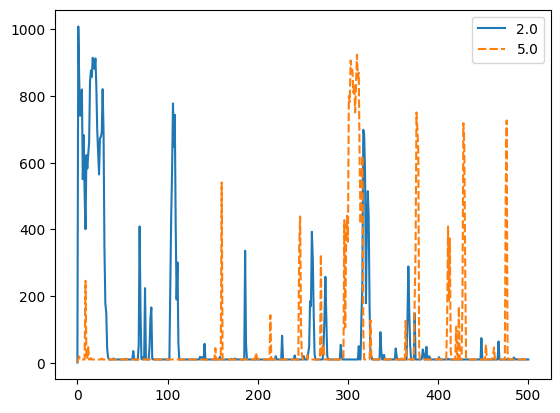

In [12]:
sns.lineplot(R.iloc[:,:2])

<AxesSubplot: >

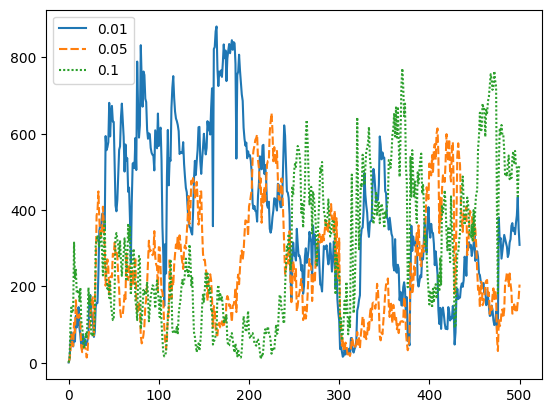

In [13]:
sns.lineplot(R.iloc[:,2:])

- (3rd, 4th plots - y-axis: mean and cumulative means of $\mu_1$, respectively; x-axis: iterations)

<AxesSubplot: >

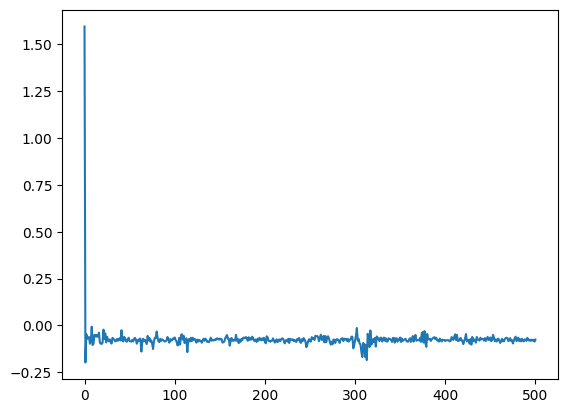

In [14]:
sns.lineplot(np.mean(mus, 1)[:,0])

C:\Users\nakaz\AppData\Local\Temp\ipykernel_16232\2920802307.py:1: RuntimeWarning: divide by zero encountered in divide
  sns.lineplot(np.cumsum(np.mean(mus,1),0)[:,0]/np.arange(len(mus)))


<AxesSubplot: >

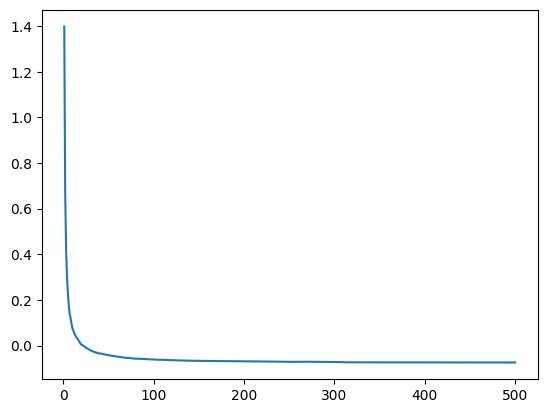

In [15]:
sns.lineplot(np.cumsum(np.mean(mus,1),0)[:,0]/np.arange(len(mus)))

- (5th, 6th plots - y-axis: mean and cumulative means of $\mu_2$, respectively; x-axis: iterations)

<AxesSubplot: >

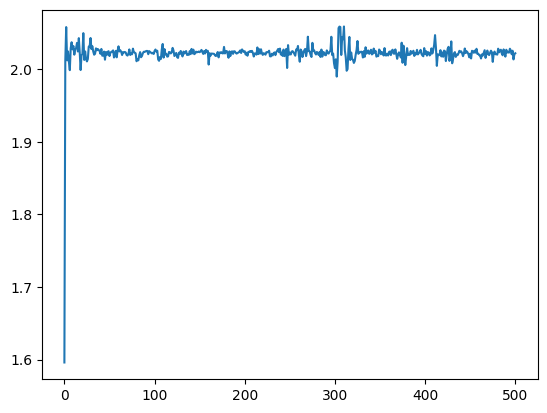

In [17]:
sns.lineplot(np.mean(mus, 1)[:,1])

C:\Users\nakaz\AppData\Local\Temp\ipykernel_16232\3724932765.py:1: RuntimeWarning: divide by zero encountered in divide
  sns.lineplot(np.cumsum(np.mean(mus,1),0)[:,1]/np.arange(len(mus)))


<AxesSubplot: >

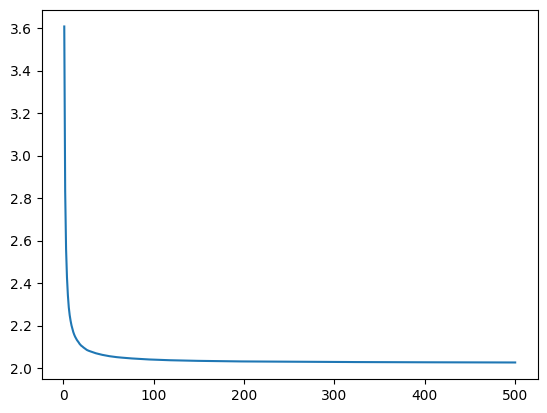

In [19]:
sns.lineplot(np.cumsum(np.mean(mus,1),0)[:,1]/np.arange(len(mus)))

We now show the same observations modeled with starting values = [-10, 10], T = 100 (as we have seen that convergence is reached rather quickly). \
Plots are displayed in the same order. \
We can see how convergence is still reached very quickly, even with starting values very far from the true values.

In [11]:
mus2, R2 = GaussianMixturePMC(X, N = 1000, V=V, T = 100, n_parameters=2, baseline_threshold = 0.01, alpha = 0.2, sigma_1=1, sigma_2=1, start_values=[-10, 10])

iteration:  0
iteration:  10
iteration:  20
iteration:  30
iteration:  40
iteration:  50
iteration:  60
iteration:  70
iteration:  80
iteration:  90


<AxesSubplot: >

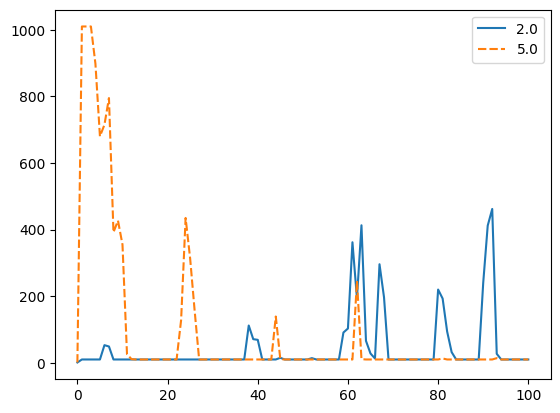

In [54]:
sns.lineplot(R2.iloc[:,:2])

<AxesSubplot: >

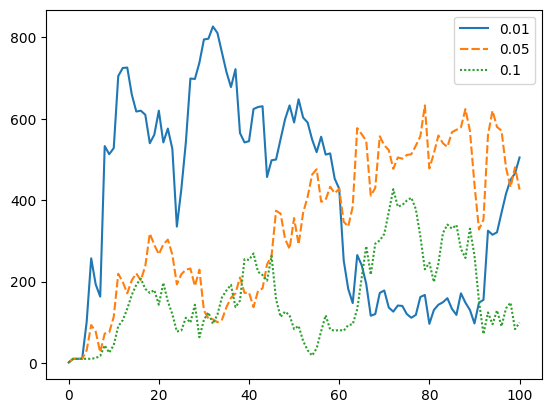

In [55]:
sns.lineplot(R2.iloc[:,2:])

<AxesSubplot: >

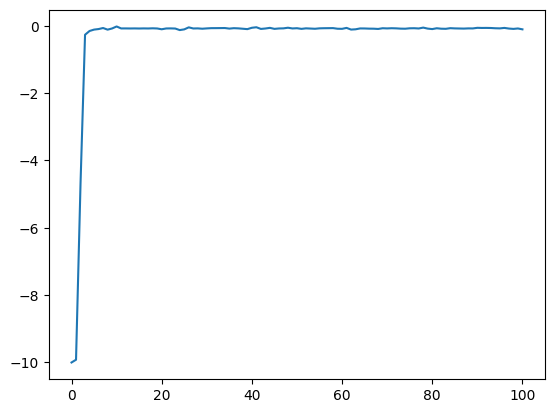

In [61]:
sns.lineplot(np.mean(mus2, 1)[:,0])

C:\Users\nakaz\AppData\Local\Temp\ipykernel_16232\2833127429.py:1: RuntimeWarning: divide by zero encountered in divide
  sns.lineplot(np.cumsum(np.mean(mus2,1),0)[:,0]/np.arange(len(mus2)))


<AxesSubplot: >

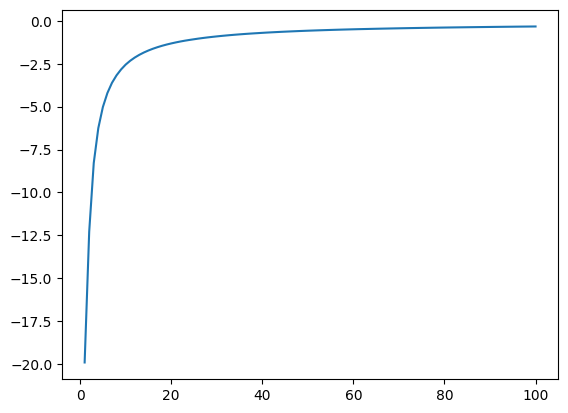

In [63]:
sns.lineplot(np.cumsum(np.mean(mus2,1),0)[:,0]/np.arange(len(mus2)))

<AxesSubplot: >

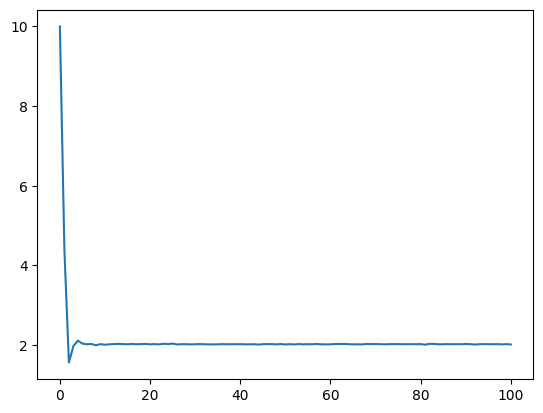

In [64]:
sns.lineplot(np.mean(mus2, 1)[:,1])

C:\Users\nakaz\AppData\Local\Temp\ipykernel_16232\2036188538.py:1: RuntimeWarning: divide by zero encountered in divide
  sns.lineplot(np.cumsum(np.mean(mus2,1),0)[:,1]/np.arange(len(mus2)))


<AxesSubplot: >

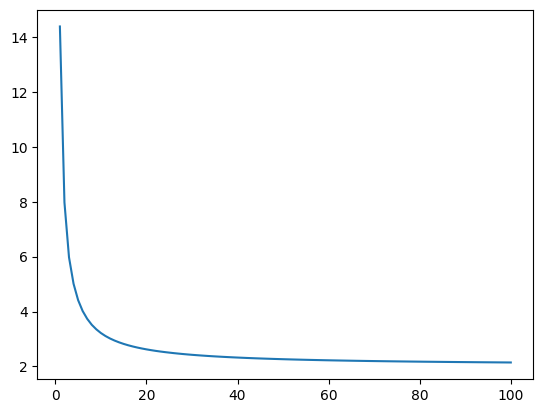

In [65]:
sns.lineplot(np.cumsum(np.mean(mus2,1),0)[:,1]/np.arange(len(mus2)))

Finally, just as a further test, we try out the model with a different mixture, with different scale parameters:
\begin{equation*}
    0.4 \mathcal{N}(0, 0.5^2) + 0.6 \mathcal{N}(3, 3^2)
\end{equation*}

In [60]:
X = generate_mixGauss(1000, mu_1 = 0, mu_2 = 3, sig_1 = 0.5, sig_2 = 3, alpha = 0.4, set_seed = 42)
V = [5, 2, 0.1, 0.05, 0.01]

In [66]:
mus3, R3 = GaussianMixturePMC(X, N = 1000, V=V, T = 100, n_parameters=2, baseline_threshold = 0.01, alpha = 0.4, sigma_1=0.5, sigma_2=3)

iteration:  0
iteration:  10
iteration:  20
iteration:  30
iteration:  40
iteration:  50
iteration:  60
iteration:  70
iteration:  80
iteration:  90


<AxesSubplot: >

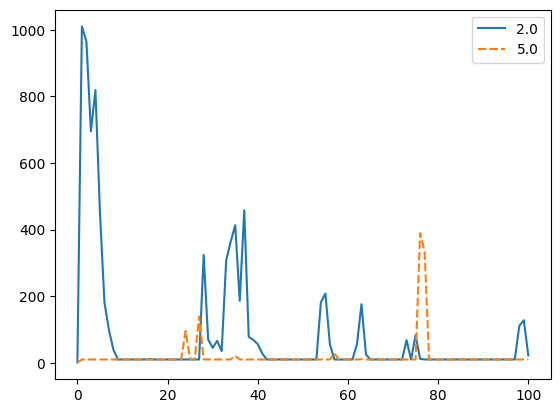

In [67]:
sns.lineplot(R3.iloc[:,:2])

<AxesSubplot: >

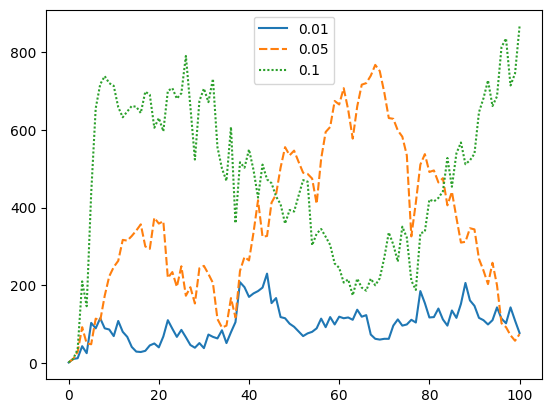

In [68]:
sns.lineplot(R3.iloc[:,2:])

<AxesSubplot: >

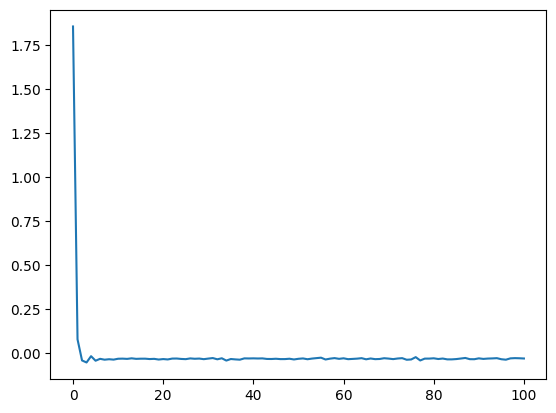

In [69]:
sns.lineplot(np.mean(mus3, 1)[:,0])

<AxesSubplot: >

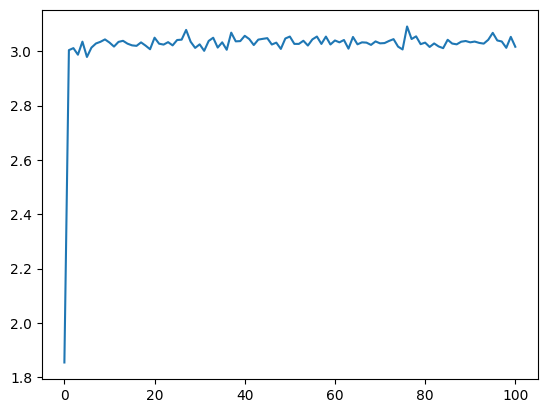

In [71]:
sns.lineplot(np.mean(mus3, 1)[:,1])